# Forecasting Usage of New York City's 311 Service  
New York City maintains an information and reporting service for city residents that permit them to source information from and report problems to City Government with greater ease.  While the service is an important enhancement to resident life, it imposes an administrative burden on the City as it must receive the requests and reports and refer them to the correct City agency.  A model that can accurately forecast usage of the service would allow the City to serve residents more efficiently.  
<br>
This analysis will search for a model with stronger predictive power than a baseline model.  Potential models will include:
- ARIMA of varying orders
- SARIMA (ARIMA with seasonality) of varying orders
- SARIMAX (SARIMA with exogenous variables) with various regressors
- Prophet, a newer and more flexible model with better handling of seasonality
- GARCH and GARCH-X, if heteroskedasticity is an issue
- Neural networks (LSTM)

In [19]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator, MultipleLocator, FuncFormatter
import seaborn as sns
from cycler import cycler

from dask import delayed, compute
from dask.distributed import Client, as_completed
import gc
import itertools
from typing import Optional, Tuple, List, Union
import time

# Modeling
from arch import arch_model

from pmdarima.arima import auto_arima

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df

from scipy.stats import boxcox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, Dropout, Flatten, GRU, Input, LSTM, MaxPooling1D 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [20]:
# Change formatting for images
%matplotlib inline

preferred_font_path = r'C:\Windows\Fonts\GIL_____.ttf'
fallback_fonts = ['Arial', 'DejaVu Sans']

try:
    fm.fontManager.addfont(preferred_font_path)
    custom_font = fm.FontProperties(fname=preferred_font_path).get_name()
    plt.rcParams['font.family'] = [custom_font] + fallback_fonts
except Exception as e:
    plt.rcParams['font.family'] = fallback_fonts

plt.rcParams['axes.prop_cycle'] = cycler(color=['#6C5B7B'])
background_color = (240/255, 240/255, 240/255)
plt.rcParams['figure.facecolor'] = background_color
plt.rcParams['axes.facecolor'] = background_color
plt.rcParams['font.family'] = custom_font
plt.rcParams['font.family'] = ['Gill Sans MT', 'Arial', 'DejaVu Sans']

In [21]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 100)

## Data Preparation
The data sources are:  
- NYC OpenData's 311 call database, which includes calls dating from January 1, 2010
- Daily weather for New York City, retrieved from OpenMeteo's API

To simplify the functioning of this notebook, the data has been processed and stored in pickle files.  To learn more about how, view the notebook titled 'NYC_311_Data_Prep.ipynb' in the Notebooks subfolder.

In [22]:
# Read in prepared data
df_311_calls = pd.read_pickle('Data/311_Calls.pickle')
df_zips = pd.read_pickle('Data/NYC_Zips.pickle')
df_weather = pd.read_pickle('Data/NYC_Weather.pickle')

#### Visualize Distributions

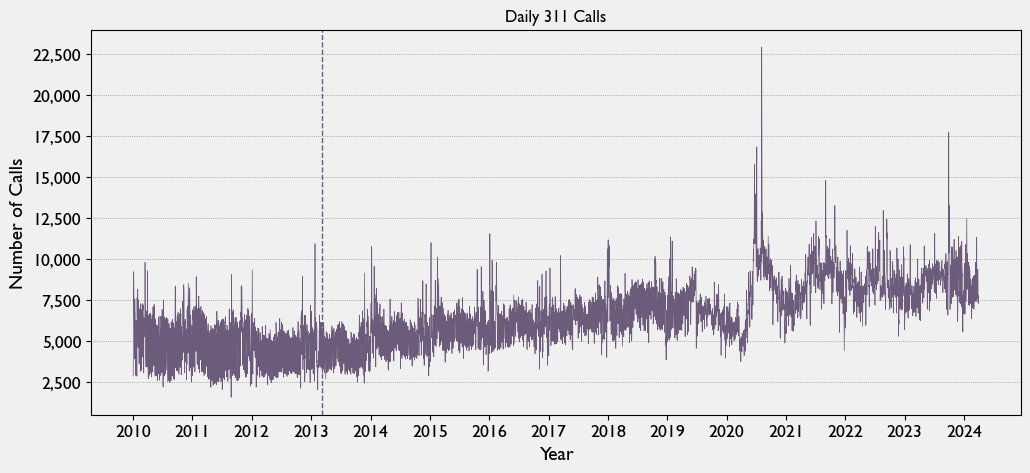

In [23]:
daily_plot = df_311_calls.groupby('Date').size()
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(daily_plot, linewidth=.5)
ax.set_xlabel('Year', fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=13)
ax.set_ylabel('Number of Calls', fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=13)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.yaxis.set_major_locator(MultipleLocator(2500))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))

ax.grid(which='major', axis='y', linestyle=':', linewidth=0.5, color='gray')
ax.axvline(pd.to_datetime('2013-03-09'), linestyle='--', linewidth=1)
output_file = 'Charts/daily_call_volume.jpg'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
ax.set_title('Daily 311 Calls')
plt.show()

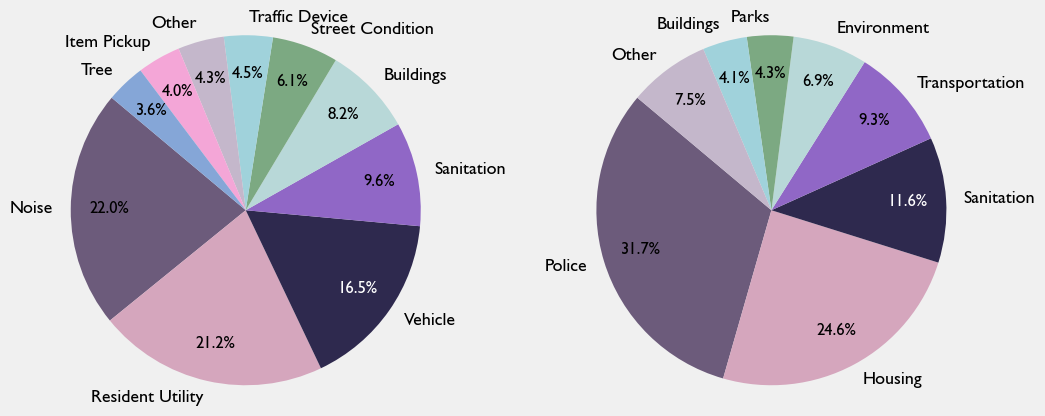

In [24]:
types = df_311_calls.groupby('Type', observed=True).size().sort_values(ascending=False)[:10]
labels = types.index.to_list()
sizes = types.values
colors = ['#6C5B7B', '#D5A6BD', '#2E294E', '#9067C6', '#B8D8D8',
          '#7CA982', '#A0D2DB', '#C4B7CB', '#F4A6D7', '#85A6D7']

agencies = df_311_calls.groupby('Agency', observed=True).size().sort_values(ascending=False)[:7]
other_size = df_311_calls.groupby('Agency', observed=True).size().sort_values(ascending=False)[7:].sum()
labels2 = agencies.index.to_list() + ['Other']
sizes2 = list(agencies.values) + [other_size]
colors2 = ['#6C5B7B', '#D5A6BD', '#2E294E', '#9067C6', '#B8D8D8',
          '#7CA982', '#A0D2DB', '#C4B7CB']

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
wedges1, texts1, autotexts1 = ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')
wedges2, texts2, autotexts2 = ax2.pie(sizes2, labels=labels2, colors=colors2, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')

for text in texts1 + texts2:
    text.set_fontsize(13)

for autotext in autotexts1 + autotexts2:
    autotext.set_fontsize(12)
    x, y = autotext.get_position()
    autotext.set_position((x * 1.3, y * 1.3))

autotexts1[2].set_color('white')
autotexts2[2].set_color('white')

plt.subplots_adjust(wspace=0.3)

output_file = 'Charts/distro_by_agency_and_type.jpg'
plt.savefig(output_file, dpi=300, bbox_inches='tight')

plt.show()

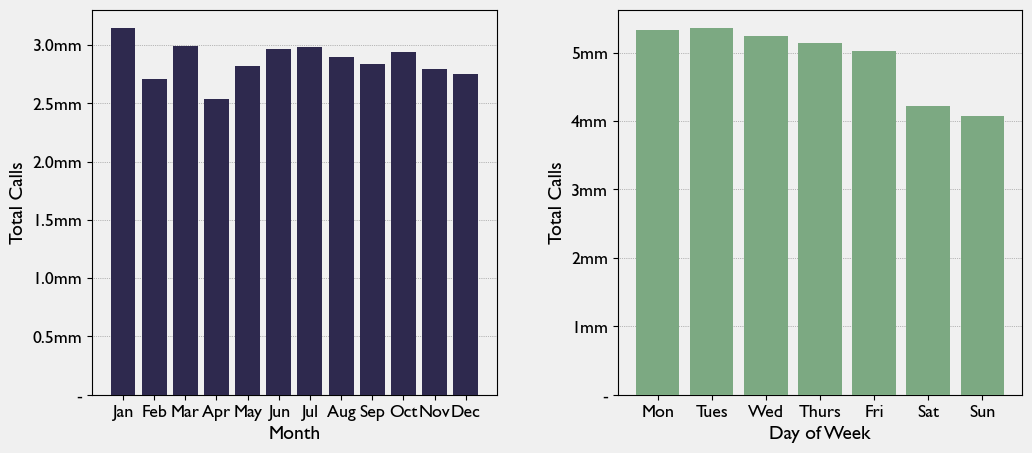

In [25]:
months = df_311_calls['Date'].dt.month.value_counts()
day_week = df_311_calls['Date'].dt.day_of_week.value_counts() 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.bar(x=months.index, height=months, color='#2E294E', zorder=3)
ax2.bar(x=day_week.index, height=day_week, color='#7CA982', zorder=3)
plt.subplots_adjust(wspace=0.3)

x1_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
y1_labels = ['-', '0.5mm', '1.0mm', '1.5mm', '2.0mm', '2.5mm', '3.0mm']
x2_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
y2_labels = ['-', '1mm', '2mm', '3mm', '4mm', '5mm']

ax1.set_xlabel('Month', fontsize=14)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(x1_labels, fontsize=13)
ax1.set_ylabel('Total Calls', fontsize=14)
ax1.set_yticks(range(0, 3500000, 500000))
ax1.set_yticklabels(y1_labels, fontsize=13)
ax1.grid(which='major', axis='y', linestyle=':', linewidth=0.5, color='gray', zorder=0)

ax2.set_xlabel('Day of Week', fontsize=14)
ax2.set_xticks(range(7))
ax2.set_xticklabels(x2_labels, fontsize=13)
ax2.set_ylabel('Total Calls', fontsize=14)
ax2.set_yticks(range(0, 6000000, 1000000))
ax2.set_yticklabels(y2_labels, fontsize=13)
ax2.grid(which='major', axis='y', linestyle=':', linewidth=0.5, color='gray', zorder=0)

output_file = 'Charts/calls_by_month_and_day_of_week.jpg'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Visual: Full period with test period shaded
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(train_series['Count'], label='Training Data', linewidth=.5, color='#2E294E')
ax.plot(test_series['Count'], label='Testing Data', linewidth=.5, color='#6C5B7B')
ax.axvspan(test_series['Count'].index[0], test_series['Count'].index[-1], color='purple', alpha=0.1)
plt.setp(ax.get_xticklabels(), fontsize=13)
ax.set_ylabel('Number of Calls', fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=13)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_locator(MultipleLocator(2500))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.grid(which='major', axis='y', linestyle=':', linewidth=0.5, color='gray')

output_file = '/Charts/daily_volume_shaded.jpg'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Visual: Only the test period
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(test_series['Count'], label='Testing Data', linewidth=1, color='#6C5B7B')
plt.setp(ax.get_xticklabels(), fontsize=13)
ax.set_ylabel('Number of Calls', fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=13)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.yaxis.set_major_locator(MultipleLocator(2500))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.grid(which='major', axis='y', linestyle=':', linewidth=.5, color='gray')

output_file = '/Charts/test_period.jpg'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()


### Weather

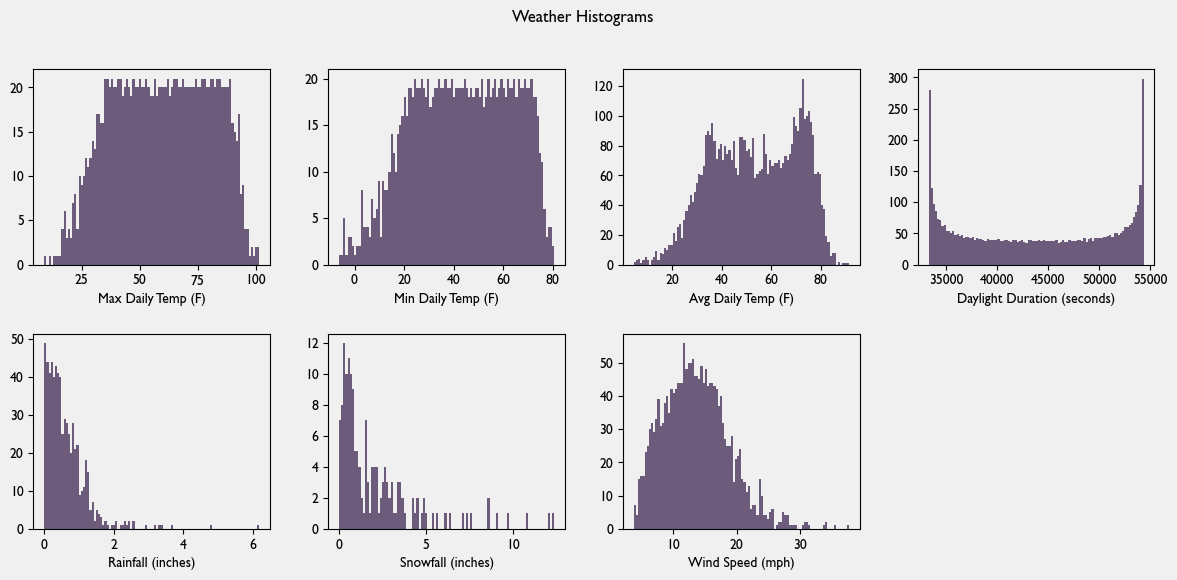

In [26]:
# Visualize weather data
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle('Weather Histograms')

ax1.hist(df_weather['temperature_2m_max'].value_counts().index, bins=100)
ax1.set_xlabel('Max Daily Temp (F)')
ax2.hist(df_weather['temperature_2m_min'].value_counts().index, bins=100)
ax2.set_xlabel('Min Daily Temp (F)')
ax3.hist(df_weather['temperature_2m_mean'].value_counts().index, bins=100)
ax3.set_xlabel('Avg Daily Temp (F)')
ax4.hist(df_weather['daylight_duration'].value_counts().index, bins=100)
ax4.set_xlabel('Daylight Duration (seconds)')
ax5.hist(df_weather['rain_sum'].value_counts().index, bins=100)
ax5.set_xlabel('Rainfall (inches)')
ax6.hist(df_weather['snowfall_sum'].value_counts().index, bins=100)
ax6.set_xlabel('Snowfall (inches)')
ax7.hist(df_weather['wind_speed_10m_max'].value_counts().index, bins=100)
ax7.set_xlabel('Wind Speed (mph)')
ax8.axis('off')
plt.tight_layout(pad=2.0)
plt.show;

#### Scaling
This data must be scaled for certain of the models, but the distributions vary.  The images above suggest the following scaling approaches: 
- Rainfall, snowfall and wind speed: Box-Cox transformation, addresses right-skewed distributions
- Temperatures - Temperatures are normally distributed when holding seasonality constant.  Seasonal decompose first, then standard scale, then seasonal recompose
- Daylight Duration - Minmax scaling

In [27]:
# Scaling functions for weather data

# log transform with a small constant
def log_transform(series, constant=1e-6):
    return np.log(series + constant)

# Helper function to apply Box-Cox transformation
def boxcox_transform(series):
    series_nonzero = series + 1e-6  # Add small constant to avoid zero values
    transformed_data, _ = boxcox(series_nonzero)
    return pd.Series(transformed_data, index=series.index)

# Seasonal decompose and recompose function
def decompose_and_scale(series, period=365):
    series = series.dropna()  # Drop NaNs if any
    decomposition = seasonal_decompose(series, model='additive', period=period)
    seasonal = decomposition.seasonal
    adjusted_series = series - seasonal  # Adjust the original series by removing the seasonal component

    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(adjusted_series.values.reshape(-1, 1))

    scaled_series_full = pd.Series(scaled_series.flatten(), index=adjusted_series.index)
    scaled_series_full = scaled_series_full.reindex(series.index).bfill().ffill()

    return scaled_series_full


In [28]:
# Applying transformations

# Temperature columns: seasonal decompose, scale, recompose
df_weather['temperature_2m_max_scaled'] = decompose_and_scale(df_weather['temperature_2m_max'])
df_weather['temperature_2m_min_scaled'] = decompose_and_scale(df_weather['temperature_2m_min'])
df_weather['temperature_2m_mean_scaled'] = decompose_and_scale(df_weather['temperature_2m_mean'])

# Daylight duration: MinMax scale
df_weather['daylight_duration_scaled'] = MinMaxScaler().fit_transform(df_weather['daylight_duration'].values.reshape(-1, 1))

# Rainfall and Snowfall: Log transform with small constant
df_weather['rain_sum_log'] = boxcox_transform(df_weather['rain_sum'])
df_weather['snowfall_sum_log'] = boxcox_transform(df_weather['snowfall_sum'])

# Wind speed: Log transform
df_weather['wind_speed_10m_max_log'] = boxcox_transform(df_weather['wind_speed_10m_max'])

df_weather.drop(columns=['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
                         'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max'], inplace=True)

df_weather.rename(columns={
    'temperature_2m_max_scaled': 'temperature_2m_max',
    'temperature_2m_min_scaled': 'temperature_2m_min',
    'temperature_2m_mean_scaled': 'temperature_2m_mean',
    'daylight_duration_scaled': 'daylight_duration',
    'rain_sum_log': 'rain_sum',
    'snowfall_sum_log': 'snowfall_sum',
    'wind_speed_10m_max_log': 'wind_speed_10m_max'
}, inplace=True)

## Modeling
A visual inspection of the dataset suggests that it has a strong autoregressive pattern, high and changing volatility, some weak seasonal patterns and likely some exogenous effects.  In order to properly characterize this data, several models will be fitted:
- A baseline model will be established using the best of:  
  1.  an AR(1) model  
  2.  a random walk model, or  
  3.  an MA(1) model  
- The first simple model will reflect best guess parameters for an ARIMA model based on a visual inspection of the data and the ACF and PACF graphs
- Using auto_arima, the ARIMA model will be optimized for pdq parameters
- The second model will reflect best guess parameters for a SARIMA model based on visual observation of the results and residuals of prior models and the ACF and PACF graphs of the residuals.
- Using auto_arima, the SARIMA model will be optimized for pdq and PDQ parameters
- Usine the best SARIMA model parameters, several exogenous regressors will be tested to determine whether they can enhance performance
- If heteroskedasticity is present, a GARCH model will be considered
- If strong seasonality is detected, Meta's Prophet model will be considered
- Finally, an LSTM model will be tested to determine whether newer, though less transparent, approaches can detect underlying patterns not found by other models
<br>
<br>
The value of forecasting to the 311 service and other agencies is to better predict necessary resources to respond to requests.  The amount of resources necessary is most directly applicable to mean absolute error.  However, the service should place heavier emphasis on outliers.  Residents' dissatisfaction with government performance likely follows an exponential pattern, not a linear one.  20 minutes wait time is more than two times worse than 10 minutes.  Two weeks for an agency to respond is more than twice as bad as one week.  **Root mean squared error** captures both the scale of the problem and the importance of outliers.  When using grid search to select parameters, **Akaike Information Criterion** will be used to select the winning combination. 

In [29]:
# Identify future target columns
target_cols = ['Agency', 'Type', 'Zip']

# Create Master dataset to use for modeling
df_311_dates_drop = df_311_calls.drop(columns=target_cols, axis=1)
time_series = df_311_dates_drop.groupby('Date').size().reset_index(name='Count')
time_series.set_index('Date', inplace=True)

# Dummy for COVID period
lockdown1 = pd.date_range(start='2020-03-21', end='2020-06-06', inclusive='both')
lockdown2 = pd.date_range(start='2021-07-09', end='2021-10-27', inclusive='both')
lockdown3 = pd.date_range(start='2021-02-13', end='2021-02-17', inclusive='both')
lockdown4 = pd.date_range(start='2021-05-28', end='2021-06-10', inclusive='both')
lockdowns = lockdown1.union(lockdown2).union(lockdown3).union(lockdown4)

time_series['covid'] = time_series.index.isin(lockdowns) * 1
time_series['winter'] = (time_series.index.month <= 2) * 1
time_series['weekend'] = (time_series.index.dayofweek >= 5) * 1
time_series['311_app'] = (time_series.index >= pd.Timestamp('2013-03-19')) * 1

time_series = pd.concat([time_series, df_weather], axis=1)

In [30]:
# Interpolate NYC population using US Census estimates
population_data = {
    'date': pd.to_datetime(['2010-01-01', '2010-07-01', '2011-07-01', '2012-07-01', '2013-07-01', '2014-07-01',
                            '2015-07-01', '2016-07-01', '2017-07-01', '2018-07-01', '2019-07-01',
                            '2020-04-01', '2020-07-01', '2021-07-01', '2022-07-01', '2023-07-01', '2024-03-31']),
    'population': [8175133, 8190209, 8251281, 8312676, 8374527, 8436839, 8499614, 8562857, 8626570, 8690757, 8755421, 8804199, 8740292, 8462216, 8335798, 8258035, 8200257]
}

# Create DataFrame
population_df = pd.DataFrame(population_data)

# Set the date as index
population_df.set_index('date', inplace=True)

# Generate a date range from 2010-01-01 to 2024-03-31
date_range = pd.date_range(start='2010-01-01', end='2024-03-31', freq='D')

# Reindex the population data to the full date range, using interpolation to fill in the gaps
population_daily_df = population_df.reindex(date_range)
population_daily_df['population'] = population_daily_df['population'].interpolate(method='linear')

# Scale population numbers
population_daily_df['population'] = MinMaxScaler().fit_transform(population_daily_df['population'].values.reshape(-1, 1))

time_series = pd.concat([time_series, population_daily_df], axis=1)
time_series = time_series.asfreq('D')

In [31]:
test_size = 731         # two years plus one day

split_point = len(time_series) - test_size
train_df = time_series.iloc[:split_point]
test_df = time_series.iloc[split_point:]

<br>

In [73]:
# Function to perform a rolling forecast over a test set using a given horizon
# Returns the final model, the predictions on the fitted values from the first model, and the predictions made on each horizon over the test set

def rolling_forecast(train_series: pd.Series,
                     test_series: pd.Series,
                     pdq: Tuple[int, int, int],
                     seasonal_pdq: Optional[Tuple[int, int, int, int]] = None,
                     exog_train: Optional[pd.DataFrame] = None,
                     exog_test: Optional[pd.DataFrame] = None,
                     maxiter: int = 50,
                     start_params: Optional[List[float]] = None,
                     forecast_horizon: int = 1,
                     initialization: Optional[str] = None) -> Union[Tuple[pd.Series, List[float], SARIMAX], Tuple[pd.Series, List[float], SARIMAX]]:
    
    history = list(train_series)
    exog_history = exog_train.values.tolist() if exog_train is not None else None
    predictions = []
    total_steps = len(test_series)
    start_time = time.time()

    train_pred = None
    
    for t in range(0, total_steps, forecast_horizon):
        if exog_history is not None:
            model = SARIMAX(history, exog=exog_history, order=pdq, seasonal_order=seasonal_pdq, initialization=initialization)
            model_fit = model.fit(disp=False, maxiter=maxiter, start_params=start_params)
            steps = min(forecast_horizon, total_steps - t)
            yhat = model_fit.forecast(steps=steps, exog=exog_test.iloc[t:t+steps])
            exog_history.extend(exog_test.iloc[t:t+steps].values)
            if t == 0:
                train_pred = model_fit.fittedvalues
        else:
            model = SARIMAX(history, order=pdq, seasonal_order=seasonal_pdq, initialization=initialization)
            model_fit = model.fit(disp=False, maxiter=maxiter, start_params=start_params)
            steps = min(forecast_horizon, total_steps - t)
            yhat = model_fit.forecast(steps=steps)
            if t == 0:
                train_pred = model_fit.fittedvalues

        predictions.extend(yhat)
        history.extend(test_series.iloc[t:t+steps])

        if len(history) > len(train_series) + forecast_horizon:  # Limits training size to the initial length
            history = history[steps:]
            if exog_history is not None:
                exog_history = exog_history[steps:]

        gc.collect()  # Fx creates hundreds of models; this releases the memory as each new model is fitted, improves computational performance

        if (t // forecast_horizon + 1) % (100 // forecast_horizon) == 0 or t + steps >= total_steps:
            elapsed_time = time.time() - start_time
            print(f"Progress: {min(t + forecast_horizon, total_steps)} out of {total_steps} steps completed in {elapsed_time} seconds")
            start_time = time.time()

    return train_pred, predictions, model_fit

### Choosing a Baseline Model

##### AR(1) Model

In [33]:
# ARIMA (1, 0, 0)
arima_100_train_pred, arima_100_test_pred, arima_100_model = rolling_forecast(train_df['Count'], test_df['Count'], (1, 0, 0))

Progress: 100 out of 731 steps completed in 11.511626720428467 seconds
Progress: 200 out of 731 steps completed in 12.268904685974121 seconds
Progress: 300 out of 731 steps completed in 12.268149375915527 seconds
Progress: 400 out of 731 steps completed in 11.845395565032959 seconds
Progress: 500 out of 731 steps completed in 11.909162759780884 seconds
Progress: 600 out of 731 steps completed in 11.961440801620483 seconds
Progress: 700 out of 731 steps completed in 11.850759267807007 seconds
Progress: 731 out of 731 steps completed in 3.817753791809082 seconds


In [34]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], arima_100_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], arima_100_test_pred)}')

RMSE on training set: 1215.000642192471
RMSE on test set: 1129.6448233396275


In [35]:
arima_100_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4474
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -37801.673
Date:                Sun, 26 May 2024   AIC                          75607.345
Time:                        12:27:47   BIC                          75620.157
Sample:                             0   HQIC                         75611.861
                               - 4474                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9871      0.002    422.386      0.000       0.983       0.992
sigma2      1.277e+06    1.3e+04     97.882      0.000    1.25e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  52.66   Jarque-Bera (JB):              9526.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.96
Prob(H) (two-sided):                  0.19   Kurtosis:                         9.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br>

##### Random Walk

In [36]:
# ARIMA (0, 1, 0)
arima_010_train_pred, arima_010_test_pred, arima_010_model = rolling_forecast(train_df['Count'], test_df['Count'], (0, 1, 0), maxiter=500)

C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 100 out of 731 steps completed in 18.784427404403687 seconds
Progress: 200 out of 731 steps completed in 14.449493646621704 seconds
Progress: 300 out of 731 steps completed in 14.065783739089966 seconds
Progress: 400 out of 731 steps completed in 14.433695554733276 seconds
Progress: 500 out of 731 steps completed in 14.182271718978882 seconds
Progress: 600 out of 731 steps completed in 13.862579345703125 seconds
Progress: 700 out of 731 steps completed in 13.974637031555176 seconds
Progress: 731 out of 731 steps completed in 4.4689295291900635 seconds


In [37]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], arima_010_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], arima_010_test_pred)}')

RMSE on training set: 1220.2428670532076
RMSE on test set: 1130.171820889745


In [38]:
arima_010_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4474
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -37806.031
Date:                Sun, 26 May 2024   AIC                          75614.061
Time:                        12:29:36   BIC                          75620.467
Sample:                             0   HQIC                         75616.319
                               - 4474                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.272e+06   1.27e+04    100.026      0.000    1.25e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  53.02   Jarque-Bera (JB):              9196.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.94
Prob(H) (two-sided):                  0.15   Kurtosis:                         9.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br>

##### MA(1) Model

In [39]:
# ARIMA (0, 0, 1)
arima_001_train_pred, arima_001_test_pred, arima_001_model = rolling_forecast(train_df['Count'], test_df['Count'], (0, 0, 1))

Progress: 100 out of 731 steps completed in 34.585373878479004 seconds
Progress: 200 out of 731 steps completed in 34.56773924827576 seconds
Progress: 300 out of 731 steps completed in 34.42525601387024 seconds
Progress: 400 out of 731 steps completed in 35.17475938796997 seconds
Progress: 500 out of 731 steps completed in 34.506160497665405 seconds
Progress: 600 out of 731 steps completed in 35.1728675365448 seconds
Progress: 700 out of 731 steps completed in 35.50679850578308 seconds
Progress: 731 out of 731 steps completed in 10.956572771072388 seconds


In [40]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], arima_001_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], arima_001_test_pred)}')

RMSE on training set: 3617.0004062264293
RMSE on test set: 4776.865055214732


In [41]:
arima_001_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4474
Model:               SARIMAX(0, 0, 1)   Log Likelihood              -43345.309
Date:                Sun, 26 May 2024   AIC                          86694.618
Time:                        12:33:50   BIC                          86707.430
Sample:                             0   HQIC                         86699.134
                               - 4474                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9100      0.006    154.824      0.000       0.898       0.921
sigma2      1.522e+07   3.08e-11   4.94e+17      0.000    1.52e+07    1.52e+07
===================================================================================
Ljung-Box (L1) (Q):                 156.04   Jarque-Bera (JB):              1867.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

<br>

**AR(1) is the baseline**: AR(1) and Random Walk both have RMSE ~ 1130.  AR(1) is slightly lower, so this will serve as the comparison going forward.

<br>

### First Simple Model: ARIMA
ARIMA will look for autoregressive and moving average terms that will lead to improvements against the baseline.  ARIMA models are applied to "stationary" data sets.  The Augmented Dickey-Fuller test will test to determine whether this data is stationary.  Large negative statistics, and p-values under 0.05, imply that the data *is* stationary. 

In [42]:
result = adfuller(time_series['Count'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.5208859123946588
p-value: 0.11047490316084208


<b><span style="color:red">Not stationary</span></b>.  Because the p-value is not less than 0.05, the data is not stationary and must be transformed.  The first transformation will use the one-day difference.

In [43]:
# Transform the data by taking the one-day difference
time_series['Count_diff'] = time_series['Count'].diff().dropna()
result_diff = adfuller(time_series['Count_diff'].dropna())
print(f'ADF Statistic (1st diff): {result_diff[0]}')
print(f'p-value (1st diff): {result_diff[1]}')

ADF Statistic (1st diff): -21.56754139806522
p-value (1st diff): 0.0


<b><span style="color:#15B01A">Stationary</span></b>.  The data is now stationary so the future 'd' term will be 1.  Now, the Autocorrelation Function CF and PACF to look for good p and q terms, and check for seasonality. 

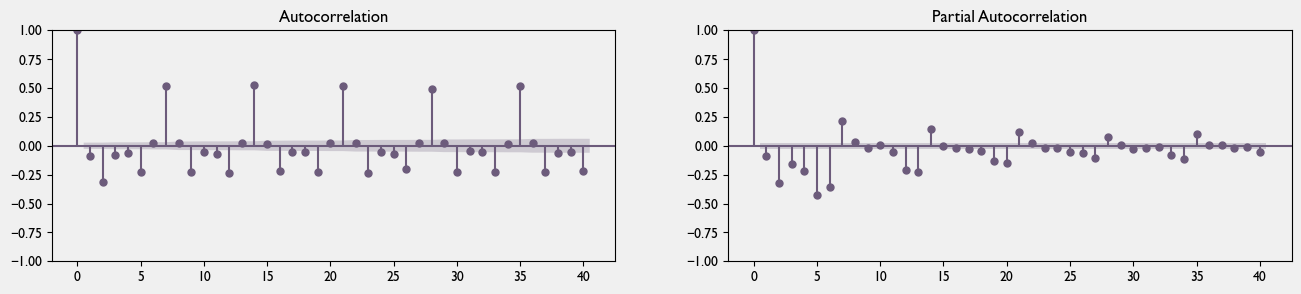

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(time_series['Count_diff'].dropna(), lags=40, ax=axes[0])
plot_pacf(time_series['Count_diff'].dropna(), lags=40, ax=axes[1]);

The drop-off after 1 term in each chart suggests that p=1 and q=1 will lead to better results.  However, the oscillation makes it difficult to determine what the right term actually will be.  Notably, the 7-day pattern outside of the confidence interval suggests seasonality.

The simple first model, will use ARIMA (1,1,1), based on visual inspection of the ACF and PACF.  Then a grid search will recommend the best set of 'pdq' to use.

In [45]:
# ARIMA (1, 1, 1)
arima_111_train_pred, arima_111_test_pred, arima_111_model = rolling_forecast(train_df['Count'], test_df['Count'], (1, 1, 1))

Progress: 100 out of 731 steps completed in 46.4556303024292 seconds
Progress: 200 out of 731 steps completed in 45.380430459976196 seconds
Progress: 300 out of 731 steps completed in 47.65519309043884 seconds
Progress: 400 out of 731 steps completed in 46.71436357498169 seconds
Progress: 500 out of 731 steps completed in 47.706132888793945 seconds
Progress: 600 out of 731 steps completed in 45.90917229652405 seconds
Progress: 700 out of 731 steps completed in 48.01122498512268 seconds
Progress: 731 out of 731 steps completed in 15.344128370285034 seconds


In [46]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], arima_111_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], arima_111_test_pred)}')

RMSE on training set: 1067.694664773531
RMSE on test set: 989.4160484574766


In [47]:
arima_111_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4474
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -37235.882
Date:                Sun, 26 May 2024   AIC                          74477.765
Time:                        12:39:34   BIC                          74496.982
Sample:                             0   HQIC                         74484.538
                               - 4474                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4779      0.012     40.893      0.000       0.455       0.501
ma.L1         -0.9522      0.004   -239.891      0.000      -0.960      -0.944
sigma2       9.95e+05   9102.446    109.311      0.000    9.77e+05    1.01e+06
===================================================================================
Ljung-Box (L1) (Q):                  43.09   Jarque-Bera (JB):             16712.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.20
Prob(H) (two-sided):                  0.91   Kurtosis:                        12.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

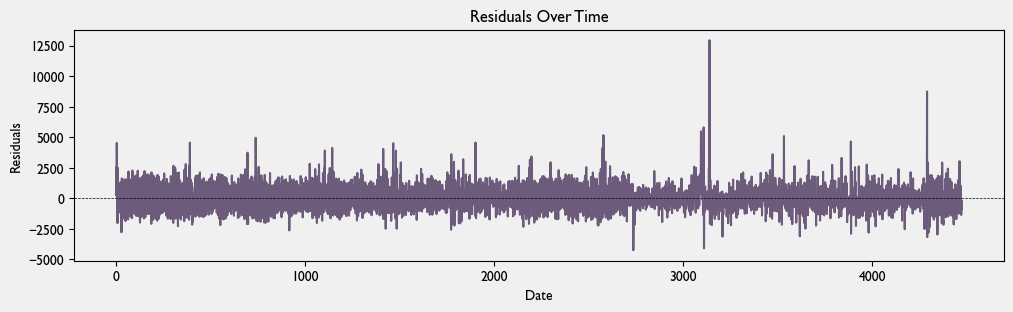

In [48]:
plt.figure(figsize=(12, 3))
plt.plot(arima_111_model.resid, label='Residuals', color='#6C5B7B')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

<br>

**ARIMA(1, 1, 1) is the new best model**. At RMSE = 989, this model is a significant improvement.  Grid search will look for a better combination.

<br>

In [49]:
arima_model = auto_arima(train_df['Count'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=74701.430, Time=2.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76253.783, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76231.363, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=75948.244, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76251.787, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=74749.518, Time=1.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=74696.394, Time=1.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=75058.083, Time=0.99 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=75711.968, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=74696.933, Time=2.00 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=75602.503, Time=0.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=74685.534, Time=2.36 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=74673.564, Time=2.67 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=74535.786, Time=1.86 sec
 ARIMA(4,1,0)(0,0,0

In [50]:
# ARIMA (4, 1, 5)
arima_415_train_pred, arima_415_test_pred, arima_415_model = rolling_forecast(train_df['Count'], test_df['Count'], (4, 1, 5), maxiter=500)

C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 100 out of 731 steps completed in 1384.7859055995941 seconds
Progress: 200 out of 731 steps completed in 1178.908484697342 seconds


C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 300 out of 731 steps completed in 1058.0235238075256 seconds
Progress: 400 out of 731 steps completed in 1219.5731599330902 seconds
Progress: 500 out of 731 steps completed in 1189.8886277675629 seconds
Progress: 600 out of 731 steps completed in 1008.2869999408722 seconds
Progress: 700 out of 731 steps completed in 1220.0129661560059 seconds
Progress: 731 out of 731 steps completed in 367.1408405303955 seconds


In [51]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], arima_415_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], arima_415_test_pred)}')

RMSE on training set: 826.3183011874227
RMSE on test set: 924.4766061513161


In [52]:
arima_415_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4474
Model:               SARIMAX(4, 1, 5)   Log Likelihood              -36534.019
Date:                Sun, 26 May 2024   AIC                          73088.038
Time:                        15:04:35   BIC                          73152.096
Sample:                             0   HQIC                         73110.616
                               - 4474                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8019      0.003    309.094      0.000       0.797       0.807
ar.L2         -1.4403      0.003   -498.358      0.000      -1.446      -1.435
ar.L3          0.7960      0.003    235.301      0.000       0.789       0.803
ar.L4         -0.9948      0.002   -503.762      0.000      -0.999      -0.991
ma.L1         -1.3215      0.010   -127.362      0.000      -1.342      -1.301
ma.L2          1.7877      0.012    143.239      0.000       1.763       1.812
ma.L3         -1.5130      0.019    -79.504      0.000      -1.550      -1.476
ma.L4          1.3277      0.014     95.660      0.000       1.301       1.355
ma.L5         -0.5169      0.012    -43.333      0.000      -0.540      -0.494
sigma2      9.313e+05   8608.808    108.185      0.000    9.14e+05    9.48e+05
===================================================================================
Ljung-Box (L1) (Q):                  42.41   Jarque-Bera (JB):             95364.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.77   Skew:                             1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.88e+14. Standard errors may be unstable.
"""

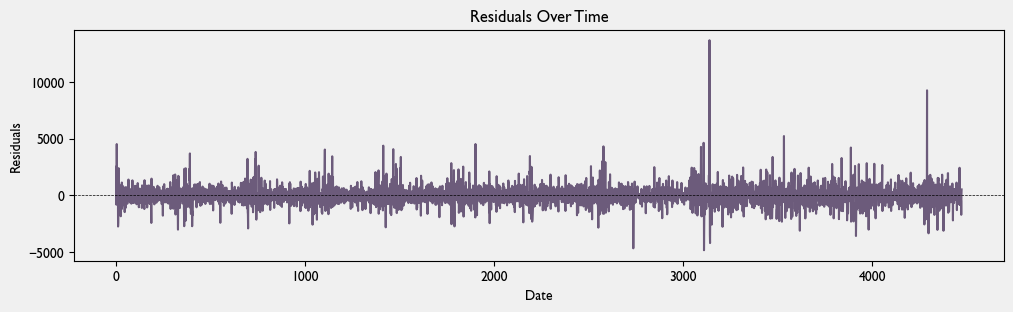

In [53]:
plt.figure(figsize=(12, 3))
plt.plot(arima_415_model.resid, label='Residuals', color='#6C5B7B')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

**UPDATE THIS CELL** **Significant improvement**. At RMSE = 924, the optimal ARIMA model is modestly better than ARIMA(1,1,1).  The next model will attempt to improve performance by taking account of seasonality.  
<br>

### SARIMA for seasonality
The ACF/PACF plots suggested seasonality.  SARIMA is a form of ARIMA model that detects and models seasonality as well (though only one form).  Like ARIMA, SARIMA requires stationary data.

In [54]:
time_series['week_diff'] = time_series['Count_diff'].diff(7)
results_adf_7d = adfuller(time_series['week_diff'].dropna())
print(f'ADF Statistic (1st diff): {results_adf_7d[0]}')
print(f'p-value (1st diff): {results_adf_7d[1]}')

ADF Statistic (1st diff): -21.428598158127986
p-value (1st diff): 0.0


7-day differencing results in stationarity.  'D' term will be 1 as well.

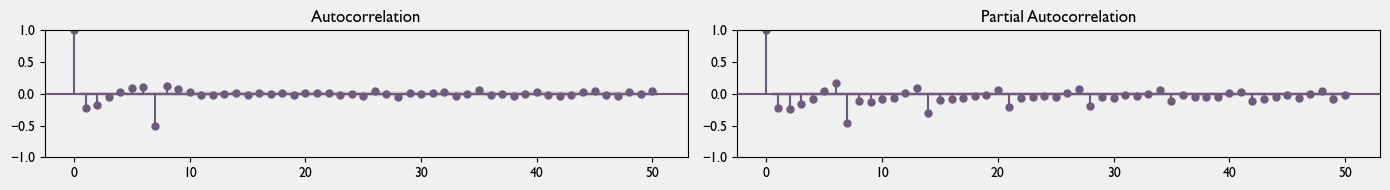

In [55]:
# Plot ACF and PACF of seasonally differenced residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 2))
plot_acf(time_series['week_diff'].dropna(), ax=ax[0], lags=50)
plot_pacf(time_series['week_diff'].dropna(), ax=ax[1], lags=50)
plt.tight_layout()
plt.show()

**MA(Q) = 1**:  The ACF chart rebounds to zero by the second week.  
**AR(P) = 1**:  The PACF chart appears to rebound to zero by the sixth week, which is a very high order.  The P term cannot be determined from this chart.   
<br>
To be conservative, the first SARIMA model will be (1,1,1) (1,1,1) with 7-day seasonality.

In [57]:
sarima_111x111_train_pred, sarima_111x111_test_pred, sarima_111x111_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                            (1, 1, 1), (1, 1, 1, 7), maxiter=500)

C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 100 out of 731 steps completed in 406.8776104450226 seconds
Progress: 200 out of 731 steps completed in 403.01129722595215 seconds
Progress: 300 out of 731 steps completed in 361.5121736526489 seconds
Progress: 400 out of 731 steps completed in 374.56997323036194 seconds
Progress: 500 out of 731 steps completed in 348.5952751636505 seconds
Progress: 600 out of 731 steps completed in 377.2838203907013 seconds
Progress: 700 out of 731 steps completed in 365.3731713294983 seconds
Progress: 731 out of 731 steps completed in 117.33849930763245 seconds


In [58]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], sarima_111x111_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], sarima_111x111_test_pred)}')

RMSE on training set: 779.2310117438527
RMSE on test set: 1477931576.2864265


This test predicted 40 billion calls for one date, which was certainly a technical glitch.  Rather than rerun the model, this value was removed from the predictions and the actuals for this test alone

In [64]:
# Remove the problematic value
test_df_filtered = test_df.drop(index=max_pred_date)
sarima_111x111_test_pred_filtered = np.delete(sarima_111x111_test_pred, max_pred_index)

print(f"Removed value for {max_pred_date}: {sarima_111x111_test_pred[max_pred_index]}")

# Recalculate RMSE
rmse_test_filtered = root_mean_squared_error(test_df_filtered['Count'], sarima_111x111_test_pred_filtered)
print(f'RMSE on test set (without problematic value): {rmse_test_filtered}')

Removed value for 2022-06-12 00:00:00: 39958862192.31543
RMSE on test set (without problematic value): 896.8257420747296


In [59]:
sarima_111x111_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4474
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -36115.146
Date:                           Sun, 26 May 2024   AIC                          72240.293
Time:                                   15:57:15   BIC                          72272.314
Sample:                                        0   HQIC                         72251.580
                                          - 4474                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5246      0.010     51.037      0.000       0.504       0.545
ma.L1         -0.9437      0.005   -203.191      0.000      -0.953      -0.935
ar.S.L7        0.0598      0.012      4.947      0.000       0.036       0.083
ma.S.L7       -0.9554      0.004   -244.505      0.000      -0.963      -0.948
sigma2      6.165e+05   3594.651    171.496      0.000    6.09e+05    6.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):            117042.71
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                             1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

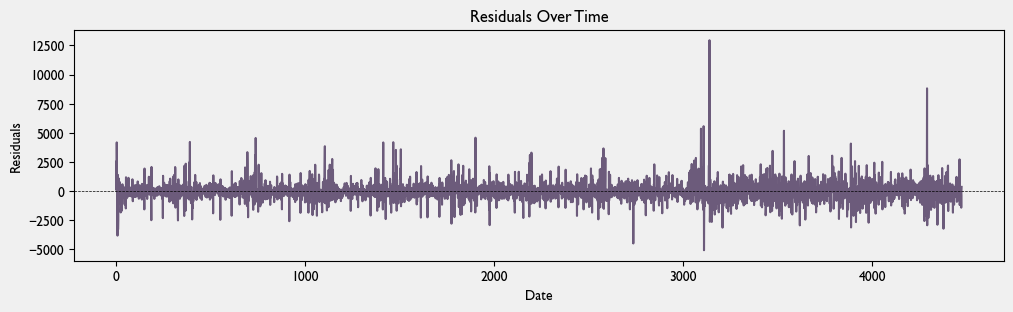

In [60]:
plt.figure(figsize=(12, 3))
plt.plot(sarima_111x111_model.resid, label='Residuals', color='#6C5B7B')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

<br>

**SARIMA(1,1,1) (1,1,1,7)**. At RMSE=896, SARIMA (1,1,1) x (1,1,1,7) improves modestly on ARIMA.  A grid search will look for better parameters.

In [67]:
sarima_opt_model = auto_arima(train_df['Count'],
                              seasonal=True,
                              m=7,
                              max_P = 5,
                              max_Q = 5,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=4.34 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=76253.783, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=74468.999, Time=0.89 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=75101.537, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=76251.787, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=76231.363, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=73787.767, Time=1.98 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=73496.393, Time=4.87 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=73365.741, Time=8.49 sec
 ARIMA(1,1,0)(5,0,0)[7] intercept   : AIC=inf, Time=23.88 sec
 ARIMA(1,1,0)(4,0,1)[7] intercept   : AIC=73825.052, Time=16.95 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=inf, Time=11.17 sec
 ARIMA(1,1,0)(5,0,1)[7] intercept   : AIC=inf, Time=39.23 sec
 ARIMA(0,1,0)(4,0,0)[7] intercept   : AIC=73553.214, Time=5.95 sec
 ARIMA(2,1,0)(4,0,0)[7] intercept   : A

In [74]:
sarima_210x401_model = sarima_opt_model
sarima_210x401_train_pred, sarima_210x401_test_pred, sarima_210x401_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                             (2, 1, 0), (4, 0, 1, 7), maxiter=500,
                                                                                             initialization='approximate_diffuse')

Progress: 100 out of 731 steps completed in 1200.080267906189 seconds
Progress: 200 out of 731 steps completed in 1268.8062002658844 seconds
Progress: 300 out of 731 steps completed in 1326.7539472579956 seconds
Progress: 400 out of 731 steps completed in 1316.167602777481 seconds
Progress: 500 out of 731 steps completed in 1451.6439163684845 seconds
Progress: 600 out of 731 steps completed in 1442.0951325893402 seconds
Progress: 700 out of 731 steps completed in 1335.701144695282 seconds
Progress: 731 out of 731 steps completed in 404.96302676200867 seconds


In [75]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], sarima_210x401_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], sarima_210x401_test_pred)}')

RMSE on training set: 808.5525694348487
RMSE on test set: 943.0612756521538


In [77]:
sarima_opt_model2 = auto_arima(train_df['Count'],
                               seasonal=True,
                               m=7,
                               D = 1,
                               max_P = 5,
                               max_Q = 5,
                               trace=True,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=72342.536, Time=7.77 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=75684.245, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=73174.697, Time=1.60 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=72643.923, Time=2.44 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=75682.279, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[7] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(2,0,2)(1,1,0)[7] intercept   : AIC=73158.202, Time=4.23 sec
 ARIMA(2,0,2)(2,1,1)[7] intercept   : AIC=72353.682, Time=12.53 sec
 ARIMA(2,0,2)(1,1,2)[7] intercept   : AIC=inf, Time=11.79 sec
 ARIMA(2,0,2)(0,1,0)[7] intercept   : AIC=74342.793, Time=1.30 sec
 ARIMA(2,0,2)(0,1,2)[7] intercept   : AIC=72418.740, Time=10.81 sec
 ARIMA(2,0,2)(2,1,0)[7] intercept   : AIC=72729.682, Time=11.87 sec
 ARIMA(2,0,2)(2,1,2)[7] intercept   : AIC=inf, Time=12.62 sec
 ARIMA(1,0,2)(1,1,1)[7] intercept   : AIC=inf, Time=6.12 sec
 ARIMA(2,0,1)(1,1,1)[7] intercept   : 

In [79]:
sarima_203x111_model = sarima_opt_model
sarima_203x111_train_pred, sarima_203x111_test_pred, sarima_203x111_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                             (2, 0, 3), (1, 1, 1, 7), maxiter=500,
                                                                                             initialization='approximate_diffuse')

C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Progress: 100 out of 731 steps completed in 944.587217092514 seconds
Progress: 200 out of 731 steps completed in 941.4528648853302 seconds
Progress: 300 out of 731 steps completed in 915.2684814929962 seconds
Progress: 400 out of 731 steps completed in 945.2517898082733 seconds
Progress: 500 out of 731 steps completed in 942.3195884227753 seconds
Progress: 600 out of 731 steps completed in 914.9404003620148 seconds
Progress: 700 out of 731 steps completed in 932.9527199268341 seconds
Progress: 731 out of 731 steps completed in 297.359254360199 seconds


In [80]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], sarima_203x111_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], sarima_203x111_test_pred)}')

RMSE on training set: 762.948712833477
RMSE on test set: 896.2924635590065


<br>

The grid search found parameters that performed very well on the training set, but performed the same as our lower order SARIMAX (1,1,1) x (1,1,1,7) model.  For simplicity, the lower order model will remain the one to beat.

&nbsp;

### SARIMAX  
The SARIMAX model is an extension of the SARIMA model that accounts for exogenous variables.  This calculation will include variables for COVID lockdowns, population, weekends, the introduction of the 311 App, winter months and different weather metrics

The first iteration will include the winning SARIMA model and will add all available exogenous variables.  All variables have been scaled:
- Daily minimum, maximum and average temperatures in Fahrenheit
- Daily rainfall and snowfall in inches
- Daily sunlight in seconds
- Daily wind speed in mph
- Whether the day is a weekend
- Whether there was a COVID lockdown occurring

In [82]:
exog_cols = ['covid', 'rain_sum', 'temperature_2m_min', 'wind_speed_10m_max', 'daylight_duration', 'temperature_2m_mean'] 
model = SARIMAX(train_df['Count'], train_df[exog_cols], order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False, maxiter=500)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Count   No. Observations:                 4473
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -35839.682
Date:                           Sun, 26 May 2024   AIC                          71701.364
Time:                                   21:59:10   BIC                          71771.808
Sample:                               01-01-2010   HQIC                         71726.195
                                    - 03-31-2022                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
covid                -420.6041    131.870     -3.190      0.001    -679.065    -162.143
rain_sum               -8.1612      1.363     -5.990      0.000     -10.832      -5.491
temperature_2m_min   -101.4405     30.871     -3.286      0.001    -161.947     -40.934
wind_speed_10m_max    161.6836     36.765      4.398      0.000      89.625     233.742
daylight_duration     826.1255    305.659      2.703      0.007     227.044    1425.207
temperature_2m_mean   -47.6936     27.976     -1.705      0.088    -102.526       7.139
ar.L1                   0.5052      0.011     46.573      0.000       0.484       0.526
ma.L1                  -0.9378      0.005   -178.603      0.000      -0.948      -0.927
ar.S.L7                 0.0444      0.013      3.336      0.001       0.018       0.070
ma.S.L7                -0.9503      0.004   -230.772      0.000      -0.958      -0.942
sigma2               5.461e+05   4089.207    133.546      0.000    5.38e+05    5.54e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):            125253.28
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
sarimax_train_pred, sarimax_test_pred, sarimax_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                  (1,1,1), (1,1,1,7),
                                                                                  train_df[exog_cols], test_df[exog_cols],
                                                                                  maxiter=500)

Progress: 100 out of 731 steps completed in 986.0058975219727 seconds
Progress: 200 out of 731 steps completed in 985.5387659072876 seconds
Progress: 300 out of 731 steps completed in 940.1966404914856 seconds
Progress: 400 out of 731 steps completed in 1022.0361289978027 seconds
Progress: 500 out of 731 steps completed in 1031.8236153125763 seconds
Progress: 600 out of 731 steps completed in 1038.1697323322296 seconds
Progress: 700 out of 731 steps completed in 1052.288682937622 seconds
Progress: 731 out of 731 steps completed in 306.86680579185486 seconds


In [86]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], sarimax_train_pred)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], sarimax_test_pred)}')

RMSE on training set: 746.9508779031821
RMSE on test set: 878.9548576248286


In [88]:
sarimax_train_pred2, sarimax_test_pred2, sarimax_model2 = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                  (2,0,3), (1,1,1,7),
                                                                                  train_df[exog_cols], test_df[exog_cols],
                                                                                  maxiter=500, initialization='approximate_diffuse')

C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Progress: 100 out of 731 steps completed in 1772.1105263233185 seconds
Progress: 200 out of 731 steps completed in 1711.5635497570038 seconds
Progress: 300 out of 731 steps completed in 1608.6575684547424 seconds
Progress: 400 out of 731 steps completed in 1750.7198944091797 seconds
Progress: 500 out of 731 steps completed in 1849.6569645404816 seconds
Progress: 600 out of 731 steps completed in 1826.3866243362427 seconds
Progress: 700 out of 731 steps completed in 1832.650689125061 seconds
Progress: 731 out of 731 steps completed in 585.210652589798 seconds


In [89]:
print(f'RMSE on training set: {root_mean_squared_error(train_df['Count'], sarimax_train_pred2)}')
print(f'RMSE on test set: {root_mean_squared_error(test_df['Count'], sarimax_test_pred2)}')

RMSE on training set: 745.9673559897017
RMSE on test set: 882.122586701979


<br>

### GARCH-X

In [90]:
# ARCH performs better with values of 1-1000
scaled_y = train_df[['Count']]/1000
scaled_test_y = test_df[['Count']] / 1000

# External regressors
exog_cols = ['covid', 'weekend', '311_app', 'temperature_2m_mean', 'daylight_duration', 'rain_sum', 'wind_speed_10m_max']
exog_train = train_df[exog_cols]
exog_test = test_df[exog_cols]

In [91]:
# Grid search for GARCH-X
p_values = range(1,9)
q_values = range(1,3)
lags_values = range(1,9)

best_aic = np.inf
best_params = None

for p, q, lags in itertools.product(p_values, q_values, lags_values):
    try:
        garch_model = arch_model(scaled_y, vol='Garch', p=p, q=q, mean='ARX', lags=lags, x=exog_train)
        garch_fit = garch_model.fit(disp="off")
        aic = garch_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_params = (p, q, lags)
    except Exception as e:
        print(f"Error fitting model with p={p}, q={q}, lags={lags}: {e}")

print(f"Best AIC: {best_aic}")
print(f"Best parameters: p={best_params[0]}, q={best_params[1]}, lags={best_params[2]}")

Best AIC: 9717.698362533149
Best parameters: p=7, q=1, lags=8


In [92]:
# Get training predictions to evaluate fitted model using RMSE
garch_model = arch_model(scaled_y, vol='Garch', p=1, q=1, mean='ARX', lags=1, x=exog_train)
garch_fit = garch_model.fit(disp="off")

params = garch_fit.params
fitted_values = np.zeros_like(scaled_y.values.flatten())

for i in range(8, len(scaled_y)):  # Start from 8 due to the 8 lags
    mean = params['Const']
    
    # Add the AR terms (lags)
    for lag in range(1, 8 + 1):  # p = 7
        if i - lag >= 0:
            mean += params[f'Count[{lag}]'] * scaled_y.values[i - lag]
    
    # Add the exogenous variables
    for exog in exog_train.columns:
        mean += params[exog] * exog_train[exog].values[i]
    
    fitted_values[i] = mean.item() if hasattr(mean, 'item') else mean

# Rescale the fitted values back to the original scale
fitted_values_original_scale = fitted_values * 1000

# Calculate actual values in the original scale
actuals_original_scale = scaled_y.values.flatten()[8:] * 1000

# Calculate RMSE using the rescaled fitted values
print(f'RMSE: {root_mean_squared_error(actuals_original_scale, fitted_values_original_scale[8:])}')

RMSE: 823.5458544627757


In [93]:
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.794
Mean Model:                      AR-X   Adj. R-squared:                  0.793
Vol Model:                      GARCH   Log-Likelihood:               -4833.85
Distribution:                  Normal   AIC:                           9717.70
Method:            Maximum Likelihood   BIC:                           9877.80
                                        No. Observations:                 4465
Date:                Mon, May 27 2024   Df Residuals:                     4449
Time:                        07:25:22   Df Model:                           16
                                       Mean Model                                       
========================================================================================
                           coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------------------------------------------------------------------
Const                    0.1150      0.108      1.064      0.287    [-9.684e-02,  0.327]
Count[1]                 0.4101  2.098e-02     19.549  4.216e-85       [  0.369,  0.451]
Count[2]                -0.0119  1.301e-02     -0.913      0.361  [-3.739e-02,1.363e-02]
Count[3]                 0.0797  1.469e-02      5.422  5.901e-08     [5.086e-02,  0.108]
Count[4]                 0.0363  1.246e-02      2.913  3.580e-03   [1.187e-02,6.071e-02]
Count[5]                 0.1106  1.694e-02      6.528  6.648e-11     [7.738e-02,  0.144]
Count[6]                 0.0998  1.410e-02      7.074  1.507e-12     [7.212e-02,  0.127]
Count[7]                 0.3596  3.603e-02      9.982  1.836e-23       [  0.289,  0.430]
Count[8]                -0.1701  2.136e-02     -7.963  1.676e-15       [ -0.212, -0.128]
covid                    0.1350      0.141      0.955      0.340       [ -0.142,  0.412]
weekend                 -1.0270  8.371e-02    -12.269  1.335e-34       [ -1.191, -0.863]
311_app                  0.1009  3.184e-02      3.169  1.532e-03     [3.849e-02,  0.163]
temperature_2m_mean     -0.0387  1.204e-02     -3.218  1.293e-03 [-6.232e-02,-1.514e-02]
daylight_duration   -6.1994e-03  3.878e-02     -0.160      0.873  [-8.220e-02,6.980e-02]
rain_sum            -4.8925e-03  1.109e-03     -4.410  1.032e-05 [-7.067e-03,-2.718e-03]
wind_speed_10m_max       0.2335  3.773e-02      6.190  6.018e-10       [  0.160,  0.307]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1702  2.678e-02      6.356  2.071e-10      [  0.118,  0.223]
alpha[1]       0.3214  4.597e-02      6.990  2.751e-12      [  0.231,  0.411]
alpha[2]       0.0574  4.929e-02      1.165      0.244   [-3.917e-02,  0.154]
alpha[3]       0.1703  6.631e-02      2.568  1.024e-02    [4.030e-02,  0.300]
alpha[4]       0.0318  2.310e-02      1.378      0.168 [-1.345e-02,7.710e-02]
alpha[5]   3.4693e-03  1.104e-02      0.314      0.753 [-1.817e-02,2.511e-02]
alpha[6]       0.0392  1.752e-02      2.238  2.520e-02  [4.874e-03,7.353e-02]
alpha[7]       0.2152  4.441e-02      4.847  1.255e-06      [  0.128,  0.302]
beta[1]        0.0000  8.779e-02      0.000      1.000      [ -0.172,  0.172]
=============================================================================

Covariance estimator: robust
"""

In [95]:
# Rolling forecast using GARCH-X
horizon = 1
garch_test_preds = []

for i in range(0, len(test_df), horizon):
    end_idx = min(i + horizon, len(test_df))
    forecast_horizon = end_idx - i
    
    # Extend the training set with each new observation from the test set
    extended_train_y = np.concatenate([scaled_y.values.flatten(), scaled_test_y.values[:i].flatten()])
    extended_exog = np.concatenate([exog_train.values, exog_test.values[:i]], axis=0)
    
    # Fit the model with the extended data
    rolling_garch_model = arch_model(extended_train_y, vol='Garch', p=2, q=2, mean='ARX', lags=2, x=extended_exog)
    rolling_garch_fit = rolling_garch_model.fit(disp="off")
    
    # Forecast the next period (horizon)
    forecast_exog = exog_test.values[i:end_idx].reshape((len(exog_cols), forecast_horizon, 1))
    forecast = rolling_garch_fit.forecast(horizon=forecast_horizon, x=forecast_exog)
    garch_test_preds.extend(forecast.mean.iloc[-forecast_horizon:].values.flatten())

# Rescale the test predictions back to the original scale
garch_test_preds = np.array(garch_test_preds) * 1000

# Calculate actual values in the original scale
actuals_train = train_df['Count'].values
actuals_test = test_df['Count'].values

In [96]:
print(f'RMSE on test set: {root_mean_squared_error(actuals_test, garch_test_preds)}')

RMSE on test set: 1267.5877594361627


&nbsp;

### SARIMA + GARCH

In [103]:
sarimax_resid = sarimax_train_pred - train_df['Count']

scaled_resid = sarimax_resid * .1
garch_resid_model = arch_model(scaled_resid, vol='Garch', p=1, q=1)
garch_resid_fit = garch_resid_model.fit(disp="off")
conditional_volatility = garch_resid_fit.conditional_volatility

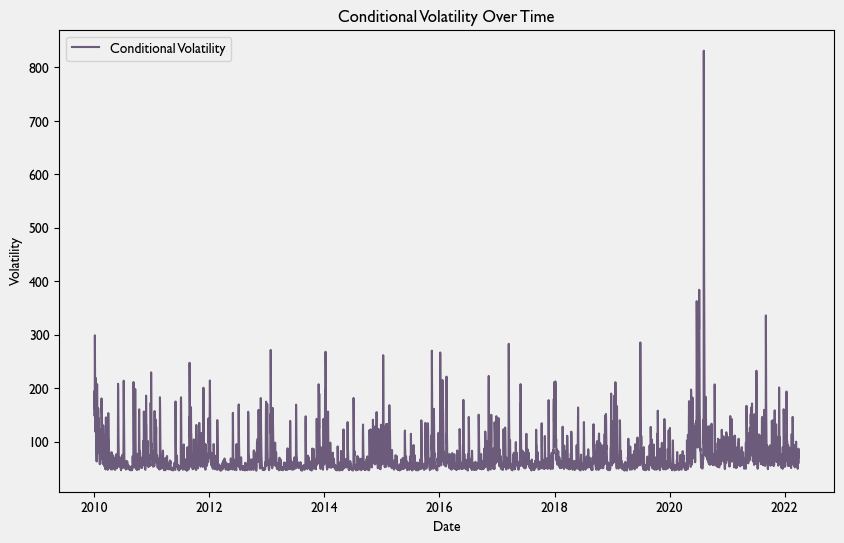

In [104]:
plt.figure(figsize=(10, 6))
plt.plot(conditional_volatility, label='Conditional Volatility')
plt.title('Conditional Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [ ]:
# Combine SARIMAX and GARCH predictions
def hybrid_forecast(train, test, sarimax_order, seasonal_order, garch_p, garch_q):
    # Fit SARIMAX model on training data
    sarimax_model = SARIMAX(train, order=sarimax_order, seasonal_order=seasonal_order)
    sarimax_fit = sarimax_model.fit(disp=False)
    
    # Get SARIMAX residuals
    sarimax_residuals = sarimax_fit.resid
    
    # Fit GARCH model on SARIMAX residuals
    garch_model = arch_model(sarimax_residuals, vol='Garch', p=garch_p, q=garch_q)
    garch_fit = garch_model.fit(disp="off")
    
    # Predict using SARIMAX model
    sarimax_forecast = sarimax_fit.get_forecast(steps=len(test))
    sarimax_mean = sarimax_forecast.predicted_mean
    
    # Predict volatility using GARCH model
    garch_forecast = garch_fit.forecast(horizon=len(test))
    garch_volatility = garch_forecast.variance.values[-1, :]
    
    # Combine predictions
    combined_forecast = sarimax_mean + garch_volatility
    
    return combined_forecast

### Appendix: LTSM

In [ ]:
time_series.columns

In [ ]:
features_to_drop = ['Count', 'covid', 'winter', 'wind_speed_10m_max', 'population']

# Assuming 'time_series' is your DataFrame
df = time_series.drop(columns=['Count_diff', 'week_diff'], axis=1).copy()

# Ensure the DataFrame is sorted by date
df = df.sort_index()

# Separate features and target
features = df.drop(columns=features_to_drop)
target = df[['Count']]

# Scale the target using MinMaxScaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

# Combine scaled features and scaled target for sequence creation
scaled_data = np.concatenate((scaled_target, features.values), axis=1)

# Function to create sequences
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 1:])  # All columns except the target for input
        y.append(data[i + time_steps, 0])  # Target column for output
    return np.array(X), np.array(y)

time_steps = 28  # Number of time steps to look back
X, y = create_sequences(scaled_data, time_steps)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build a hybrid CNN-LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(time_steps, X.shape[2])))
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2))
lstm_model.add(Bidirectional(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Bidirectional(GRU(50, return_sequences=False, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(25, kernel_regularizer=l2(0.01)))
lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
lstm_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, callbacks=[early_stopping])

# Predict and invert the scaling
train_predictions = lstm_model.predict(X_train)
test_predictions = lstm_model.predict(X_test)

train_predictions = target_scaler.inverse_transform(train_predictions)
test_predictions = target_scaler.inverse_transform(test_predictions)

# Inverse transform y_train and y_test for comparison
train_actual = target_scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
train_lstm_rmse = root_mean_squared_error(train_actual, train_predictions)
test_lstm_rmse = root_mean_squared_error(test_actual, test_predictions)


print('LSTM model errors')
print('-------------------------')
print(f'Train RMSE: {train_lstm_rmse:.1f}')
print('-------------------------')
print(f'Test RMSE: {test_lstm_rmse:.1f}')


In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[time_steps:split + time_steps], train_actual, label='Train Actual')
plt.plot(df.index[time_steps:split + time_steps], train_predictions, label='Train Predictions', linestyle='--')
plt.plot(df.index[split + time_steps:], test_actual, label='Test Actual')
plt.plot(df.index[split + time_steps:], test_predictions, label='Test Predictions', linestyle='--')
plt.legend()
plt.show()

<br>

### Appendix: Prophet
Prophet is a good model when there is strong seasonality or multiple seasonalities.  While there is some seasonality in this data, it is week relative to the types of business problem at which Prophet excels.  Prophet is also not as strong when dealing with data that has a strong autoregressive element, or data which is heteroskedastic, both of which characterize this data.  Nonetheless, Prophet was fitted to see if it might provide value, particularly in light of its ability to model several seasonalities and its ability to handle holiday effects.  While it did not perform terribly, it was not as strong as SARIMA, GARCH, or a hybrid approach.

In [ ]:
df_311_encoded = pd.get_dummies(df_311_calls, columns=['Agency']).drop(columns=['Type','Zip','Borough'],axis=1)
time_series_encoded = df_311_encoded.groupby('Date').sum()

In [ ]:
prophet_df = pd.concat([time_series, time_series_encoded], axis=1).drop(columns=['Count_diff','week_diff'],axis=1)

In [ ]:
columns_to_sum = ['Agency_Consumer','Agency_Finance','Agency_Homeless','Agency_Human Resources','Agency_Other','Agency_Taxi']
prophet_df['Agency_Misc'] = prophet_df[columns_to_sum].sum(axis=1)
prophet_df.drop(columns=columns_to_sum, inplace=True)

In [ ]:
test_size = 731         # two years plus one day

split_point = len(prophet_df) - test_size
prophet_train = prophet_df.iloc[:split_point]
prophet_test = prophet_df.iloc[split_point:]

In [ ]:
def create_prophet_model(train_series: pd.Series, weekly: bool, monthly: bool, yearly: bool, holidays: pd.DataFrame) -> Prophet:
    model = Prophet(yearly_seasonality=yearly, weekly_seasonality=weekly, holidays=holidays)
    
    if monthly:
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    return model

def evaluate_prophet_model(weekly: bool, monthly: bool, yearly: bool, train_series: pd.Series, holidays: pd.DataFrame, horizon: str) -> tuple:
    model = create_prophet_model(train_series, weekly, monthly, yearly, holidays)
    df = train_series.reset_index().rename(columns={'index': 'ds', train_series.name: 'y'})
    model.fit(df)
    
    initial = '730 days'
    period = '180 days'
    
    df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)
    df_p = performance_metrics(df_cv)
    
    rmse = df_p['rmse'].mean()
    return rmse, model

def grid_search_prophet(train_df: pd.DataFrame, feature: str, holidays: pd.DataFrame) -> tuple:
    seasonality_options = [True, False]
    best_rmse = np.inf
    best_config = None
    best_model = None
    
    client = Client()
    futures = []
    
    for weekly, monthly, yearly in itertools.product(seasonality_options, repeat=3):
        future = delayed(evaluate_prophet_model)(weekly, monthly, yearly, train_df[feature], holidays, horizon='730 days')
        futures.append(future)

    futures = client.compute(futures)
    
    for future in as_completed(futures):
        try:
            rmse, fitted_model = future.result()
            if rmse < best_rmse:
                best_rmse = rmse
                best_config = (weekly, monthly, yearly)
                best_model = fitted_model
        except ValueError as e:
            print(f"Skipping configuration due to error: {e}")
    
    client.close()
    
    if best_model is not None:
        final_rmse, final_model = evaluate_prophet_model(best_config[0], best_config[1], best_config[2], train_df[feature], holidays, horizon='1 day')
    else:
        final_rmse, final_model = np.inf, None
    
    return best_config, final_rmse, final_model

In [ ]:
# Create and concatenate all holidays into a single variable

# Add US holidays
us_holidays = make_holidays_df(year_list=range(2010, 2025), country='US')

# Create a special COVID lockdown "holiday" category
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# NYC-specific events
nyc_marathon = pd.DataFrame({
    'holiday': 'NYC Marathon',
    'ds': pd.to_datetime(['2010-11-07','2011-11-06','2013-11-03','2014-11-02','2015-11-01','2016-11-06',
                          '2017-11-05','2018-11-04','2019-11-03','2021-11-07','2022-11-06','2023-11-05']),
    'lower_window': 0,
    'upper_window': 1,
})

nyc_storms = pd.DataFrame({
    'holiday': 'NYC Storms',
    'ds': pd.to_datetime(['2011-08-27','2011-08-28','2011-08-29','2011-10-29','2011-10-30','2011-10-31',
                          '2016-01-22','2016-01-23','2016-01-24','2016-01-25','2020-08-04','2020-08-05',
                          '2023-09-29', '2023-09-30']),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat([us_holidays, nyc_marathon, nyc_storms, lockdowns])

In [ ]:
best_config, best_rmse, best_model = grid_search_prophet(prophet_train, 'Count', holidays)

print(f'Best Configuration: Weekly={best_config[0]}, Monthly={best_config[1]}, Yearly={best_config[2]}')
print(f'Best RMSE: {best_rmse}')

In [ ]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
df = train_df['Count'].reset_index().rename(columns={'index': 'ds', train_df['Count'].name: 'y'})
model.fit(df)

In [ ]:
train_df_temp = train_df.reset_index().rename(columns={'index': 'ds'})
regressors_df = train_df_temp[['ds', '311_app', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'population']]

In [ ]:
feature = 'Count'
df = prophet_train[[feature]].reset_index().rename(columns={'index': 'ds', feature: 'y'})
df = df.merge(regressors_df, on='ds', how='left')

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, holidays=holidays)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

for regressor in regressors_df.columns.difference(['ds']):
    model.add_regressor(regressor)

model.fit(df)
forecast = model.predict(df)

y_true = df['y'].values
y_pred = forecast['yhat'].values

rmse = root_mean_squared_error(y_true, y_pred)
print(f'RMSE: {rmse}')

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

# Plot the forecast
fig = plot_plotly(model, forecast)
fig.show()

# Plot the forecast components
fig_components = plot_components_plotly(model, forecast)
fig_components.show()